# 数据预处理
- 检查数据集标题,跳过标题行，通关观察数据集发现，标题行有两行，分别在数据集开头和中间部分
- 检查空值

In [354]:
import pandas as pd
import numpy as np
data = pd.read_csv('Algerian_forest_fires_dataset_UPDATE.csv',skiprows=[0,124,125,126])

#空值检查
null_columns = data.columns[data.isnull().any()]
null_rows = data.index[data.isnull().any(axis=1)]

# 打印包含空值的行和列
print("Null columns:", null_columns)
print("Null rows:", null_rows)

# 打印空值的坐标
for col in null_columns:
    for row in null_rows:
        if pd.isna(data.loc[row, col]):
            print(f"Null value found at ({row}, {col})")

Null columns: Index(['Classes  '], dtype='object')
Null rows: Int64Index([165], dtype='int64')
Null value found at (165, Classes  )


- 检查到数据集中的行：14,07,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire   有问题，14.6和9之间没有逗号会导致后续数据的读取错误，所以我直接手动修改数据集添加上逗号了

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('Algerian_forest_fires_dataset_fix.csv',skiprows=[0,124,125,126])

#再次进行空值检查
null_columns = data.columns[data.isnull().any()]
null_rows = data.index[data.isnull().any(axis=1)]
for col in null_columns:
    for row in null_rows:
        if pd.isna(data.loc[row, col]):
            print(f"Null value found at ({row}, {col})")

- z-score标准化

In [2]:
mean = np.mean(data.iloc[:, :-1], axis=0)
std = np.std(data.iloc[:, :-1], axis=0)
data.iloc[:, :-1] = (data.iloc[:, :-1] - mean) / std
data.fillna(0, inplace=True)

- 标签进行编码

In [3]:
# 使用 loc 和 str.contains 选择包含 "not" 的行，将该列的值替换成 0
data.loc[data['Classes  '].str.contains('not'), 'Classes  '] = 0

# 将该列中其他行的值替换成 1
data.loc[data['Classes  '] != 0, 'Classes  '] = 1

# 构造KNN模型


- 构造KNN

In [419]:
# 导入所需的库
from sklearn.metrics.pairwise import euclidean_distances  # 导入计算两个点之间欧几里得距离的库
from collections import Counter  # 导入计数器

class KNN:
    def __init__(self, k=3):
        self.k = k  # 初始化，设定k值

    def fit(self, X, y):
        self.X_train = X  # 训练集特征
        self.y_train = y  # 训练集标签

    def distance(self, X1, X2):
        distance = euclidean_distances(
            X1.reshape(1, -1), X2.reshape(1, -1))[0][0]  # 计算两个样本点之间的欧几里得距离
        return distance

    def predict(self, X_test):
        final_output = []  # 初始化最终输出
        for i in range(len(X_test)):
            d = []  # 存放每个测试样本与训练集中所有样本之间的距离和索引
            votes = []  # 存放k个近邻样本的类别标签
            for j in range(len(self.X_train)):
                dist = self.distance(self.X_train[j], X_test[i])  # 计算测试样本与训练集样本之间的距离
                d.append([dist, j])  # 将距离和索引存储在d中
            d.sort()  # 按距离排序
            d = d[0:self.k]  # 取前k个距离最小的样本
            for dist, j in d:
                votes.append(self.y_train[j])  # 取出k个近邻样本的标签
            ans = Counter(votes).most_common(1)[0][0]  # 找到出现次数最多的标签
            final_output.append(ans)  # 将预测结果添加到final_output列表中
        return final_output

    def score(self, X_test, y_test):
        predictions = self.predict(X_test)  # 对测试集进行预测
        return (predictions == y_test).sum() / len(y_test)  # 计算分类准确率


# 评估函数

In [420]:
def evaluate(y_true, y_pred):
    TP = 0  # 真正例
    FP = 0  # 假正例
    TN = 0  # 真反例
    FN = 0  # 假反例
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
        else:
            FN += 1
    precision = TP / (TP + FP)  # 精确率
    recall = TP / (TP + FN)  # 召回率
    accuracy = (TP + TN) / (TP + TN + FP + FN)  # 准确率
    f1score = 2 * precision * recall / (precision + recall)  # F1 score
    return precision, recall, accuracy, f1score


# 训练+评估

In [421]:
from sklearn.model_selection import KFold

X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

kf = KFold(n_splits=5, shuffle=True, random_state=6666) # 设置5折交叉验证，打乱数据集，随机种子为6666
#当 K=5 时，k-fold 交叉验证会将原始数据集分为 5 个相等的部分，然后将这 5 个部分中的一个部分作为测试集，剩余的 4 个部分作为训练集，这样可以得到 5 组不同的训练集和测试集，从而可以进行 5 次训练和测试。
# 在每次训练和测试时，都会选择不同的部分作为测试集，最终将这 5 次训练和测试的结果进行平均，得到一个最终的评估结果。

results={}
for k in range(1,50):
    acc_list = []
    pre_list = []
    rec_list = []
    f1_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = KNN(k) 
        clf.fit(X_train, y_train)  # 使用训练集训练模型
        prediction = clf.predict(X_test)
        precision, recall, accuracy, f1score = evaluate(y_test, np.array(prediction))
        pre_list.append(precision)
        rec_list.append(recall)
        acc_list.append(accuracy)
        f1_list.append(f1score)
    results[k] = {'accuracy': np.mean(acc_list), 'precision': np.mean(pre_list), 'recall': np.mean(rec_list), 'f1': np.mean(f1_list)}
    print(results[k])


{'accuracy': 0.8893707482993196, 'precision': 0.9060945083014049, 'recall': 0.8987305797650624, 'f1': 0.9019874593675432}
{'accuracy': 0.8893707482993196, 'precision': 0.9060945083014049, 'recall': 0.8987305797650624, 'f1': 0.9019874593675432}
{'accuracy': 0.9181122448979592, 'precision': 0.9176146092094367, 'recall': 0.9421940128836681, 'f1': 0.928975210660654}
{'accuracy': 0.9098639455782314, 'precision': 0.9042466106690246, 'recall': 0.9413982569154984, 'f1': 0.9219017558205719}
{'accuracy': 0.9139455782312925, 'precision': 0.9005717863893615, 'recall': 0.9559871163319439, 'f1': 0.9266198650709674}
{'accuracy': 0.922108843537415, 'precision': 0.9001731601731603, 'recall': 0.9708222811671087, 'f1': 0.933637944696572}
{'accuracy': 0.8852040816326531, 'precision': 0.856719587420366, 'recall': 0.9562334217506632, 'f1': 0.9033901071605989}
{'accuracy': 0.9098639455782314, 'precision': 0.8868454367286404, 'recall': 0.9639257294429708, 'f1': 0.9235005421446101}
{'accuracy': 0.8851190476190

# 可视化

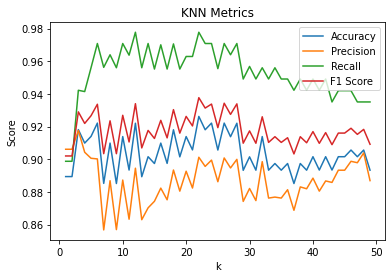

In [417]:
import matplotlib.pyplot as plt

ks = list(results.keys())  # 提取k值列表
accuracy = [x['accuracy'] for x in results.values()]  # 提取精确率列表
precision = [x['precision'] for x in results.values()]  # 提取准确率列表
recall = [x['recall'] for x in results.values()]  # 提取召回率列表
f1_score = [x['f1'] for x in results.values()]  # 提取F1分数列表

# 绘制折线图
plt.plot(ks, accuracy, label='Accuracy')
plt.plot(ks, precision, label='Precision')
plt.plot(ks, recall, label='Recall')
plt.plot(ks, f1_score, label='F1 Score')
plt.legend()  # 添加图例
plt.xlabel('k')  # 添加x轴标签
plt.ylabel('Score')  # 添加y轴标签
plt.title('KNN Metrics')  # 添加标题
plt.show()  # 显示图形

